In [1]:
import os 
from linares_plot import *

import random
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import statsmodels.formula.api as smf
from mlxtend.evaluate import permutation_test

In [15]:
os.chdir('C:\\Users\\David\\Dropbox\\IDIBAPS\\Distractor_neurons\\FR_trials')
DLPFC_0 = np.load('0_DLPFC.npy')
DLPFC_100 = np.load('100_DLPFC.npy')
DLPFC_200 = np.load('200_DLPFC.npy')
DLPFC_800 = np.load('800_DLPFC.npy')

In [32]:
def heatmap(data, title):
    ax = sns.heatmap(data,vmin=50, vmax=90, cmap= 'viridis_r',
                    cbar_kws={"shrink": .82, 'ticks' : [50, 70, 90], 'label': 'error ($^\circ$)'}) ##sns.cm.rocket_r
    ax.invert_yaxis()
    ax.figure.axes[-1].yaxis.label.set_size(15)
    plt.gca().set_ylabel('train')
    plt.gca().set_xlabel('test')
    plt.gca().set_title(title)
    plt.gca().set_xticks([0,5,10,15,20])
    plt.gca().set_xticklabels([0,5,10,15,20])
    plt.gca().set_yticks([0,5,10,15,20])
    plt.gca().set_yticklabels([0,5,10,15,20])
    plt.show(block=False)
    

def heatmap_black_white(data, title):
    ax = sns.heatmap(data,vmin=0, vmax=0.5, cmap= 'gray_r',
                    cbar_kws={"shrink": .82, 'ticks' : [0,1], 'label': 'p<0.05'}) ##sns.cm.rocket_r
    ax.invert_yaxis()
    ax.figure.axes[-1].yaxis.label.set_size(15)
    plt.gca().set_ylabel('train')
    plt.gca().set_xlabel('test')
    plt.gca().set_title(title)
    plt.gca().set_xticks([0,5,10,15,20])
    plt.gca().set_xticklabels([0,5,10,15,20])
    plt.gca().set_yticks([0,5,10,15,20])
    plt.gca().set_yticklabels([0,5,10,15,20])
    plt.show(block=False)
    
    
def circdist(a1,a2):
    ## Returns the minimal distance in angles between to angles 
    op1=abs(a2-a1)
    angs=[a1,a2]
    op2=min(angs)+(360-max(angs))
    options=[op1,op2]
    return min(options)


def decoder_tr_ts(df_train, df_test, splits=10, percentage_training=0.8, cross_val=True):
    #### Input : dataframe with three columns: (spikes, behaviour and neuron label)
    df_train.columns=['firing', 'beh', 'neuron']
    df_test.columns=['firing', 'beh', 'neuron']    
    ######
    ######## Cross validation ########
    ######## different lengths of taringn and testing #####
    errors_splits=[]
    options_train = np.arange(0, len(df_train))
    options_test = np.arange(0, len(df_test))
    for s in range(splits):
        # training
        trials_train = random.sample(list(options_train), int(percentage_training*len(options_train)))
        X_train = df_train.iloc[trials_train].firing.values
        y_train = df_train.iloc[trials_train].beh.values
        #
        if cross_val==True: ##same number of trials per neuron
            trials_test = list(set(options_train) - set(trials_train))
            X_test = df_test.iloc[trials_test].firing.values ## the trials not used for training and the rest
            y_test = df_test.iloc[trials_test].beh.values
        else:
            if len(options_train) == len(options_test):
                trials_test = list(set(options_train) - set(trials_train))
                X_test = df_test.iloc[trials_test].firing.values ## the trials not used for training and the rest
                y_test = df_test.iloc[trials_test].beh.values
            else:
                trials_test= random.sample(list(options_test), int((1-percentage_training)*len(options_test)))
                X_test = df_test.iloc[trials_test].firing.values ## the trials not used for training and the rest
                y_test = df_test.iloc[trials_test].beh.values
            
        ######## Trainning #########
        ## X matrix (intercept and spikes)
        X = np.column_stack([np.ones(np.shape(X_train)[0]), X_train])
        X = np.array(X, dtype=float) 
        ## Y (sinus and cos)
        sinus =np.sin([np.radians(np.array(y_train)[i]) for i in range(0, len(y_train))])
        cosinus = np.cos([np.radians(np.array(y_train)[i]) for i in range(0, len(y_train))])
        Y = np.column_stack([cosinus, sinus])
        ### one OLS for sin and cos: output: beta of intercetp and bea of spikes (two B intercepts and 2 B for spikes )
        model = sm.OLS(Y, X)
        ##train the model
        fit=model.fit()
        ######### Testing ###########
        X = np.column_stack([np.ones(np.shape(X_test)[0]),X_test])
        p = fit.predict(X)
        x = p[:,0]
        y = p[:,1]
        #####
        ##### Error --> take the resulting vector in sin/cos space
        ### from sin and cos get the angle (-pi, pi)
        #pred_angle = [ np.degrees(np.arctan2(y[i], x[i]) + np.pi) for i in range(0, len(y))]
        pred_angle = [ np.degrees(np.arctan2(y[i], x[i])) for i in range(0, len(y))]
        for i in range(0, len(pred_angle)):
            if pred_angle[i]<0:
                pred_angle[i]=360+pred_angle[i]
        ##
        #
        #print(beh_test)
        error_trial=[ circdist(y_test[i], pred_angle[i]) for i in range(0, len(pred_angle))]
        mean_error = np.round(np.mean(error_trial),2)
        errors_splits.append(mean_error)
    ##
    ## mean of all the splits
    mean_error = round(np.mean(errors_splits),2)

    return mean_error

In [147]:
##Signal

In [144]:
Conditions_titles = ['DLPFC_0', 'DLPFC_100', 'DLPFC_200', 'DLPFC_800']
Conditions = [DLPFC_0, DLPFC_100, DLPFC_200, DLPFC_800]

signal_neurons = [ [] for i in range(len(Conditions_titles)) ]

for cond in range(0,len(Conditions_titles)): #8  
    print(cond)
    sign_ = Conditions[cond]
    #shuff = shuff[:200, :]
    print(len(np.unique(sign_[:, 23])))
    for Neuron in np.unique(sign_[:, 23]):
        print(Neuron)
        sign_ = pd.DataFrame(sign_)
        df_neuron = sign_.loc[sign_[23] == Neuron]
        signal_ = np.zeros((22,22))
        for idx_training, training_time in enumerate(range(1, 23)):
            #print(training_time)
            df_train = df_neuron[[training_time, 0, 23]]
            df_train.columns=['rate', 'angle', 'neuron']
            df_train = df_train.dropna()
            for idx_testing, testing_time in enumerate(range(1, 23)):
                df_test = df_neuron[[testing_time, 0, 23]]
                df_test.columns=['rate', 'angle', 'neuron']
                ###
                #beh_values = df_test.angle.values.copy()
                #np.random.shuffle(beh_values)
                #df_test['angle'] = beh_values
                df_test = df_test.dropna()
                ####
                if training_time==testing_time :
                    cross_validation=True
                else:
                    cross_validation=False
                err_ = decoder_tr_ts(df_train, df_test, splits=5, percentage_training=0.8, cross_val=cross_validation)
                signal_[idx_training, idx_testing] =err_
                #
            #
        signal_neurons[cond].append(signal_)

0
63
1367701
1367802
1367903
1369702
1369901
1370002
1370202
1371202
1371901
1372003
1372301
1372402
189168701
189169502
189171003
189171602
189172801
189173101
189173801
189174201
189175201
189175801
189176101
189176501
189176901
189177402
189177701
1891783
189179001
189179002
1891793
189179702
189180001
189181001
189181502
1891819
189182202
189182501
189182901
189183201
189183402
1891841
189184601
1891857
189186201
189187301
189188901
189189601
189191601
189191602
1891918
189192001
189192201
189192401
1891935
189194301
189195301
189196301
189196401
189209101
189209503
189210001
189210901
1
63
1367701
1367802
1367903
1369702
1369901
1370002
1370202
1371202
1371901
1372003
1372301
1372402
189168701
189169502
189171003
189171602
189172801
189173101
189173801
189174201
189175201
189175801
189176101
189176501
189176901
189177402
189177701
1891783
189179001
189179002
1891793
189179702
189180001
189181001
189181502
1891819
189182202
189182501
189182901
189183201
189183402
1891841
189184601


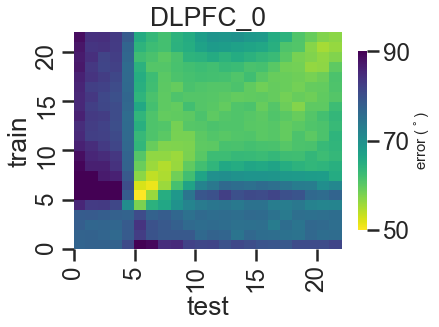

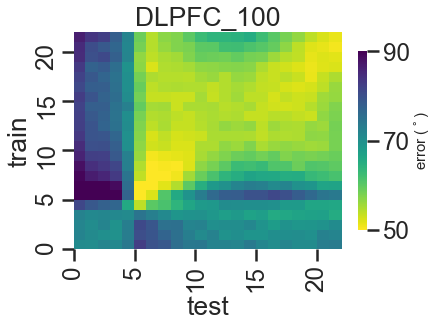

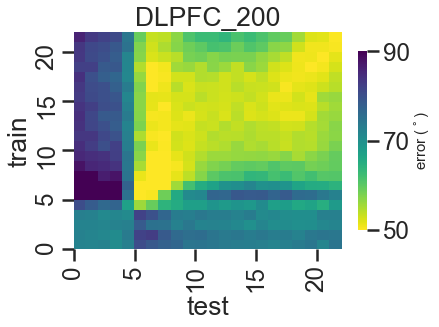

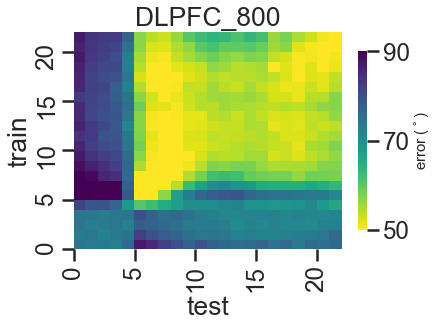

In [145]:
for idx, cond in  enumerate(['DLPFC_0', 'DLPFC_100', 'DLPFC_200', 'DLPFC_800']):
    H = [pd.DataFrame(signal_neurons[idx][x]) for x in range(len(signal_neurons[idx]))]
    H_mean = pd.concat(H).groupby(level=0).mean()
    heatmap(H_mean, cond)

In [146]:
A = np.array(signal_neurons[0])
path_save = 'C:\\Users\\David\\Desktop\\signal_HM_DLPFC_100.npy'
np.save(path_save, A)

A = np.array(signal_neurons[1])
path_save = 'C:\\Users\\David\\Desktop\\signal_HM_DLPFC_200.npy'
np.save(path_save, A)

A = np.array(signal_neurons[2])
path_save = 'C:\\Users\\David\\Desktop\\signal_HM_DLPFC_300.npy'
np.save(path_save, A)

A = np.array(signal_neurons[3])
path_save = 'C:\\Users\\David\\Desktop\\signal_HM_DLPFC_900.npy'
np.save(path_save, A)

In [ ]:
##Shuffle

In [131]:
Conditions_titles = ['DLPFC_0', 'DLPFC_100', 'DLPFC_200', 'DLPFC_800']
Conditions = [DLPFC_0, DLPFC_100, DLPFC_200, DLPFC_800]

shuffled_neurons = [ [] for i in range(len(Conditions_titles)) ]

for cond in range(0,len(Conditions_titles)): #8  
    print(cond)
    shuff = Conditions[cond]
    #shuff = shuff[:200, :]
    print(len(np.unique(shuff[:, 23])))
    for Neuron in np.unique(shuff[:, 23]):
        print(Neuron)
        shuff = pd.DataFrame(shuff)
        df_neuron = shuff.loc[shuff[23] == Neuron]
        shuffled_ = np.zeros((22,22))
        for idx_training, training_time in enumerate(range(1, 23)):
            #print(training_time)
            df_train = df_neuron[[training_time, 0, 23]]
            df_train.columns=['rate', 'angle', 'neuron']
            df_train = df_train.dropna()
            for idx_testing, testing_time in enumerate(range(1, 23)):
                df_test = df_neuron[[testing_time, 0, 23]]
                df_test.columns=['rate', 'angle', 'neuron']
                ###
                beh_values = df_test.angle.values.copy()
                np.random.shuffle(beh_values)
                df_test['angle'] = beh_values
                df_test = df_test.dropna()
                ####
                if training_time==testing_time :
                    cross_validation=True
                else:
                    cross_validation=False
                err_ = decoder_tr_ts(df_train, df_test, splits=5, percentage_training=0.8, cross_val=cross_validation)
                shuffled_[idx_training, idx_testing] =err_
                #
            #
        shuffled_neurons[cond].append(shuffled_)

            

0
63
1367701


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1367802
1367903
1369702
1369901
1370002
1370202
1371202
1371901
1372003
1372301
1372402
189168701
189169502
189171003
189171602
189172801
189173101
189173801
189174201
189175201
189175801
189176101
189176501
189176901
189177402
189177701
1891783
189179001
189179002
1891793
189179702
189180001
189181001
189181502
1891819
189182202
189182501
189182901
189183201
189183402
1891841
189184601
1891857
189186201
189187301
189188901
189189601
189191601
189191602
1891918
189192001
189192201
189192401
1891935
189194301
189195301
189196301
189196401
189209101
189209503
189210001
189210901
1
63
1367701
1367802
1367903
1369702
1369901
1370002
1370202
1371202
1371901
1372003
1372301
1372402
189168701
189169502
189171003
189171602
189172801
189173101
189173801
189174201
189175201
189175801
189176101
189176501
189176901
189177402
189177701
1891783
189179001
189179002
1891793
189179702
189180001
189181001
189181502
1891819
189182202
189182501
189182901
189183201
189183402
1891841
189184601
1891857
18918

In [132]:
np.shape(shuffled_neurons)

(4, 63, 22, 22)

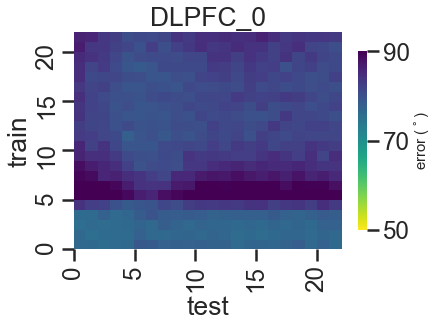

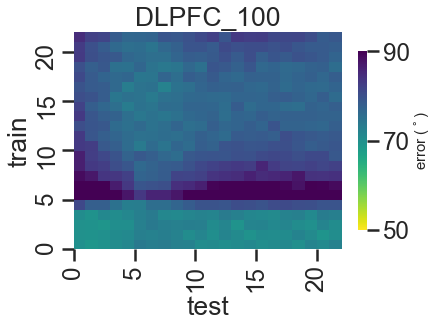

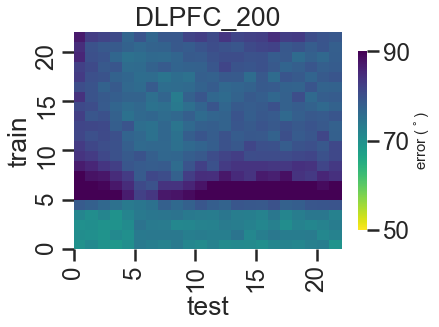

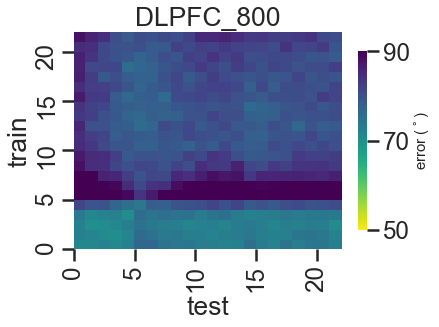

In [133]:
for idx, cond in  enumerate(['DLPFC_0', 'DLPFC_100', 'DLPFC_200', 'DLPFC_800']):
    H = [pd.DataFrame(shuffled_neurons[idx][x]) for x in range(len(shuffled_neurons[idx]))]
    H_mean = pd.concat(H).groupby(level=0).mean()
    heatmap(H_mean, cond)

In [134]:
A = np.array(shuffled_neurons[0])
path_save = 'C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_100.npy'
np.save(path_save, A)

A = np.array(shuffled_neurons[1])
path_save = 'C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_200.npy'
np.save(path_save, A)

A = np.array(shuffled_neurons[2])
path_save = 'C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_300.npy'
np.save(path_save, A)

A = np.array(shuffled_neurons[3])
path_save = 'C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_900.npy'
np.save(path_save, A)

In [135]:
# path_save = 'C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_100.xlsx'

# writer = pd.ExcelWriter(path_save)
# for idx, neuron_name in  enumerate(range(0, len(shuffled_neurons[0]))):
#     hm_ = pd.DataFrame(shuffled_neurons[0][idx])
#     hm_.to_excel(writer, sheet_name=str(neuron_name)) #each dataframe in a excel sheet

# writer.save()   #save reconstructions (heatmaps)

# path_save = 'C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_200.xlsx'

# writer = pd.ExcelWriter(path_save)
# for idx, neuron_name in  enumerate(range(0, len(shuffled_neurons[1]))):
#     hm_ = pd.DataFrame(shuffled_neurons[1][idx])
#     hm_.to_excel(writer, sheet_name=str(neuron_name)) #each dataframe in a excel sheet

# writer.save()   #save reconstructions (heatmaps)

# path_save = 'C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_300.xlsx'

# writer = pd.ExcelWriter(path_save)
# for idx, neuron_name in  enumerate(range(0, len(shuffled_neurons[2]))):
#     hm_ = pd.DataFrame(shuffled_neurons[2][idx])
#     hm_.to_excel(writer, sheet_name=str(neuron_name)) #each dataframe in a excel sheet

# writer.save()   #save reconstructions (heatmaps)

# path_save = 'C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_900.xlsx'

# writer = pd.ExcelWriter(path_save)
# for idx, neuron_name in  enumerate(range(0, len(shuffled_neurons[3]))):
#     hm_ = pd.DataFrame(shuffled_neurons[3][idx])
#     hm_.to_excel(writer, sheet_name=str(neuron_name)) #each dataframe in a excel sheet

# writer.save()   #save reconstructions (heatmaps)

In [170]:
def heatmap_black_white(data, title):
    ax = sns.heatmap(data,vmin=0, vmax=0.05, cmap= 'gray_r',
                    cbar_kws={"shrink": .82, 'ticks' : [0,1], 'label': 'p<0.05'}) ##sns.cm.rocket_r
    ax.invert_yaxis()
    ax.figure.axes[-1].yaxis.label.set_size(15)
    plt.gca().set_ylabel('train')
    plt.gca().set_xlabel('test')
    plt.gca().set_title(title)
    plt.gca().set_xticks([0,5,10,15,20])
    plt.gca().set_xticklabels([0,5,10,15,20])
    plt.gca().set_yticks([0,5,10,15,20])
    plt.gca().set_yticklabels([0,5,10,15,20])
    plt.show(block=False)

In [171]:
### Significance with the ones taken the same way!

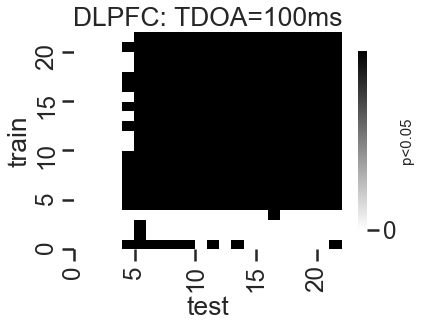

In [173]:
A = np.load('C:\\Users\\David\\Desktop\\signal_HM_DLPFC_100.npy')
B = np.load('C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_100.npy')


sign_matrix = np.ones((22,22))
for training_time in range(22):
    for testing_time in range(22):
        shuffle_distr = [B[x][training_time, testing_time] for x in range(len(B))]
        signal = [A[x][training_time, testing_time] for x in range(len(A))]
        p_value = permutation_test(signal, shuffle_distr, method='approximate', num_rounds=100, seed=0)
        sign_matrix[training_time, testing_time] = p_value
        

sign_matrix_1_0 = sign_matrix<0.05 *1
heatmap_black_white(sign_matrix_1_0, 'DLPFC: TDOA=100ms')

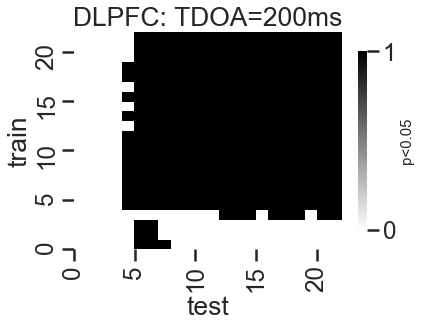

In [159]:
A = np.load('C:\\Users\\David\\Desktop\\signal_HM_DLPFC_200.npy')
B = np.load('C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_200.npy')


sign_matrix = np.ones((22,22))
for training_time in range(22):
    for testing_time in range(22):
        shuffle_distr = [B[x][training_time, testing_time] for x in range(len(B))]
        signal = [A[x][training_time, testing_time] for x in range(len(A))]
        p_value = permutation_test(signal, shuffle_distr, method='approximate', num_rounds=100, seed=0)
        sign_matrix[training_time, testing_time] = p_value
        

sign_matrix_1_0 = sign_matrix<0.05 *1
heatmap_black_white(sign_matrix_1_0, 'DLPFC: TDOA=200ms')

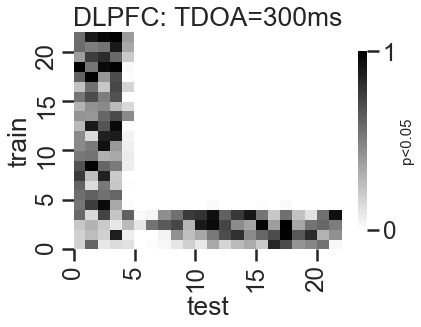

In [162]:
A = np.load('C:\\Users\\David\\Desktop\\signal_HM_DLPFC_300.npy')
B = np.load('C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_300.npy')


sign_matrix = np.ones((22,22))
for training_time in range(22):
    for testing_time in range(22):
        shuffle_distr = [B[x][training_time, testing_time] for x in range(len(B))]
        signal = [A[x][training_time, testing_time] for x in range(len(A))]
        p_value = permutation_test(signal, shuffle_distr, method='approximate', num_rounds=100, seed=0)
        sign_matrix[training_time, testing_time] = p_value
        

sign_matrix_1_0 = sign_matrix #<0.05 *1
heatmap_black_white(sign_matrix_1_0, 'DLPFC: TDOA=300ms')

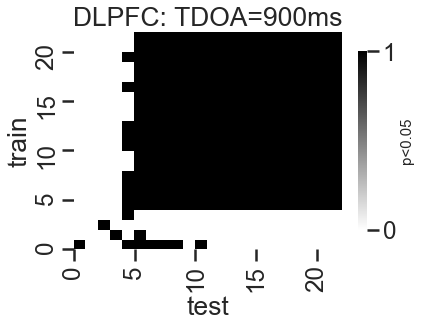

In [161]:
A = np.load('C:\\Users\\David\\Desktop\\signal_HM_DLPFC_900.npy')
B = np.load('C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_900.npy')


sign_matrix = np.ones((22,22))
for training_time in range(22):
    for testing_time in range(22):
        shuffle_distr = [B[x][training_time, testing_time] for x in range(len(B))]
        signal = [A[x][training_time, testing_time] for x in range(len(A))]
        p_value = permutation_test(signal, shuffle_distr, method='approximate', num_rounds=100, seed=0)
        sign_matrix[training_time, testing_time] = p_value
        

sign_matrix_1_0 = sign_matrix<0.05 *1
heatmap_black_white(sign_matrix_1_0, 'DLPFC: TDOA=900ms')

In [136]:
### Significance vs shuffle of the heatmaps

In [137]:
os.chdir('C:\\Users\\David\\Dropbox\\IDIBAPS\\Distractor_neurons')
cd_DLPFC_hm = np.load('cd_DLPFC_hm.npy')

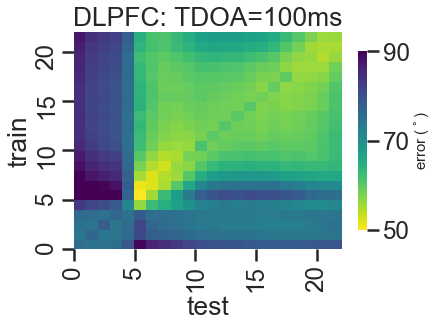

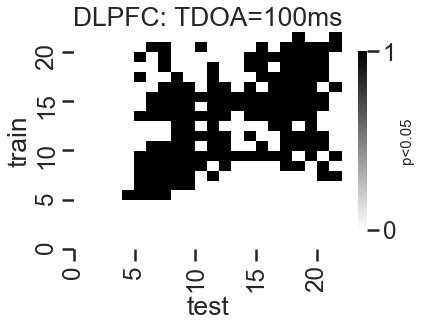

In [138]:
PFC_0 =  cd_DLPFC_hm[0]
heatmap(PFC_0, 'DLPFC: TDOA=100ms')


B = np.load('C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_100.npy')
np.shape(B)

sign_matrix = np.ones((22,22))
for training_time in range(22):
    for testing_time in range(22):
        shuffle_distr = [B[x][training_time, testing_time] for x in range(len(B))]
        signal = PFC_0[training_time, testing_time]
        p_value = permutation_test([signal], shuffle_distr, method='approximate', num_rounds=100, seed=0)
        sign_matrix[training_time, testing_time] = p_value
        

sign_matrix_1_0 = sign_matrix<0.05 *1
heatmap_black_white(sign_matrix_1_0, 'DLPFC: TDOA=100ms')
        

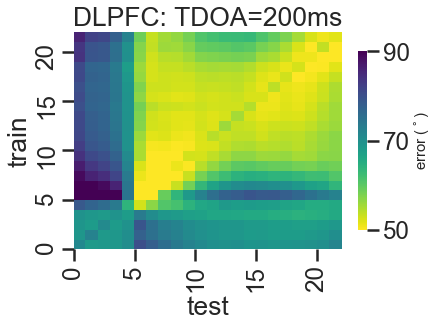

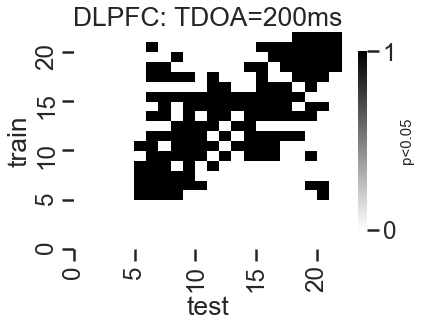

In [139]:
PFC_0 =  cd_DLPFC_hm[1]
heatmap(PFC_0, 'DLPFC: TDOA=200ms')


B = np.load('C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_200.npy')
np.shape(B)

sign_matrix = np.ones((22,22))
for training_time in range(22):
    for testing_time in range(22):
        shuffle_distr = [B[x][training_time, testing_time] for x in range(len(B))]
        signal = PFC_0[training_time, testing_time]
        p_value = permutation_test([signal], shuffle_distr, method='approximate', num_rounds=100, seed=0)
        sign_matrix[training_time, testing_time] = p_value
        

sign_matrix_1_0 = sign_matrix<0.05 *1
heatmap_black_white(sign_matrix_1_0, 'DLPFC: TDOA=200ms')

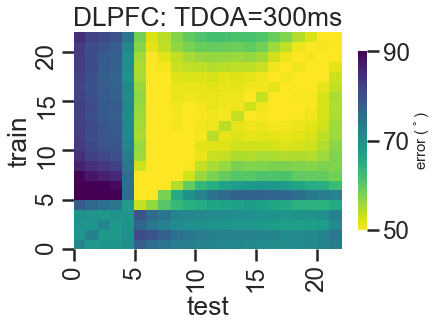

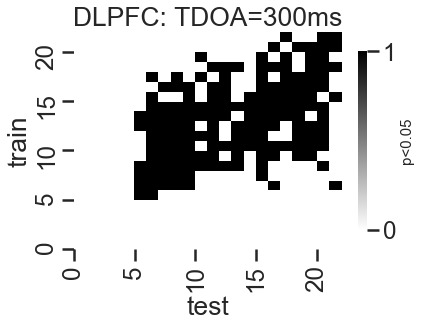

In [140]:
PFC_0 =  cd_DLPFC_hm[2]
heatmap(PFC_0, 'DLPFC: TDOA=300ms')


B = np.load('C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_300.npy')
np.shape(B)

sign_matrix = np.ones((22,22))
for training_time in range(22):
    for testing_time in range(22):
        shuffle_distr = [B[x][training_time, testing_time] for x in range(len(B))]
        signal = PFC_0[training_time, testing_time]
        p_value = permutation_test([signal], shuffle_distr, method='approximate', num_rounds=100, seed=0)
        sign_matrix[training_time, testing_time] = p_value
        

sign_matrix_1_0 = sign_matrix<0.05 *1
heatmap_black_white(sign_matrix_1_0, 'DLPFC: TDOA=300ms')

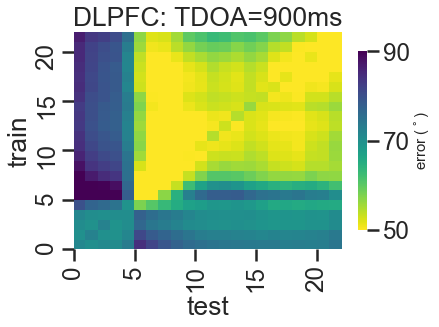

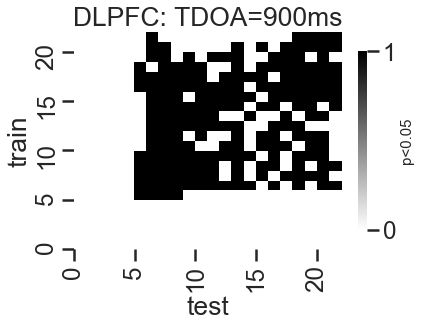

In [143]:
PFC_0 =  cd_DLPFC_hm[3]
heatmap(PFC_0, 'DLPFC: TDOA=900ms')


B = np.load('C:\\Users\\David\\Desktop\\shuffle_HM_DLPFC_900.npy')
np.shape(B)

sign_matrix = np.ones((22,22))
for training_time in range(22):
    for testing_time in range(22):
        shuffle_distr = [B[x][training_time, testing_time] for x in range(len(B))]
        signal = PFC_0[training_time, testing_time]
        p_value = permutation_test([signal], shuffle_distr, method='approximate', num_rounds=100, seed=0)
        sign_matrix[training_time, testing_time] = p_value
        

sign_matrix_1_0 = sign_matrix<0.05 *1
heatmap_black_white(sign_matrix_1_0, 'DLPFC: TDOA=900ms')
        